<a href="https://colab.research.google.com/github/Shuming13/Boostrap-4-Basics/blob/master/DGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%load_ext rpy2.ipython

# **EdgeR**

## Preprocessing

In [5]:
%%R
#install package edgeR
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("edgeR")

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


R[write to console]: Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)



In [6]:
%%R
install.packages('statmod')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/statmod_1.4.36.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 93897 bytes (91 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

In [7]:
%%R
library(edgeR)

R[write to console]: Loading required package: limma



In [8]:
%%R 

f = "/content/drive/My Drive/gene_expression_counts.csv"
dat <- read.csv(file=f,sep=';')

dat.selected <- dat[1:9865,3:8] #choose the first 6 numerical columns
d = as.matrix(dat.selected) #convert dataframe to matrix 

In [9]:
%%R 
d.full <- dat[1:9865,c(1,3:8)] #save dataset with Geneid

In [10]:
%%R

gr <- c("Cortical","Cortical","DA","DA","MN","MN") #DP=dopaminergic, MN=motor
d <- DGEList(counts=d,group=factor(gr)) #convert dataset to a DGEList

d 

An object of class "DGEList"
$counts
  Cortical_Nanopore Cortical_PacBio Dopaminergic_Nanopore Dopaminergic_PacBio
1               304              93                   180                 100
2                60              10                    23                  13
3                13              11                    14                  10
4                21               9                    13                  12
5                11               1                     6                   2
  Motor_Nanopore Motor_PacBio
1            241           98
2             53           15
3             10            9
4             33           18
5              2            2
9860 more rows ...

$samples
                         group lib.size norm.factors
Cortical_Nanopore     Cortical   907136            1
Cortical_PacBio       Cortical   285834            1
Dopaminergic_Nanopore       DA   835488            1
Dopaminergic_PacBio         DA   455202            1
Motor_Nanopore       

In [11]:
%%R

dim(d) #dataset has 6 columns and 9865 rows

[1] 9865    6


In [12]:
%%R
head(d$counts)

  Cortical_Nanopore Cortical_PacBio Dopaminergic_Nanopore Dopaminergic_PacBio
1               304              93                   180                 100
2                60              10                    23                  13
3                13              11                    14                  10
4                21               9                    13                  12
5                11               1                     6                   2
6                 7               1                     8                   2
  Motor_Nanopore Motor_PacBio
1            241           98
2             53           15
3             10            9
4             33           18
5              2            2
6             13            4


In [13]:
%%R

head(cpm(d))


  Cortical_Nanopore Cortical_PacBio Dopaminergic_Nanopore Dopaminergic_PacBio
1        335.120643      325.363673            215.442951          219.682690
2         66.142232       34.985341             27.528821           28.558750
3         14.330817       38.483875             16.756674           21.968269
4         23.149781       31.486807             15.559769           26.361923
5         12.126076        3.498534              7.181432            4.393654
6          7.716594        3.498534              9.575242            4.393654
  Motor_Nanopore Motor_PacBio
1     247.211435   211.083158
2      54.366000    32.308647
3      10.257736    19.385188
4      33.850528    38.770376
5       2.051547     4.307820
6      13.335057     8.615639


In [14]:
%%R

apply(d$counts, 2, sum) #total gene counts per sample

    Cortical_Nanopore       Cortical_PacBio Dopaminergic_Nanopore 
               907136                285834                835488 
  Dopaminergic_PacBio        Motor_Nanopore          Motor_PacBio 
               455202                974874                464272 


In [15]:
%%R
#reduce the dataset size such that keep the rows with any gene that has more 
#than 100 counts per million, and the row sum is greater than 2 

keep <- rowSums(cpm(d)>100) >= 2 
d <- d[keep,]
dim(d) #the dataset is reduced to 3280 rows

[1] 3280    6


In [16]:
%%R

#recalculate the library size for the reduced dataset
d$samples$lib.size <- colSums(d$counts)
d$samples

                         group lib.size norm.factors
Cortical_Nanopore     Cortical   703420            1
Cortical_PacBio       Cortical   232997            1
Dopaminergic_Nanopore       DA   659020            1
Dopaminergic_PacBio         DA   365966            1
Motor_Nanopore              MN   772284            1
Motor_PacBio                MN   370329            1


In [17]:
%%R
#TMM normalization is applied to this dataset to account for compositional 
#difference between the libraries
d <- calcNormFactors(d)
d

An object of class "DGEList"
$counts
   Cortical_Nanopore Cortical_PacBio Dopaminergic_Nanopore Dopaminergic_PacBio
1                304              93                   180                 100
9                140              64                   185                 134
13               133              21                    83                  26
14               524              35                    53                  30
18                46              35                   166                 100
   Motor_Nanopore Motor_PacBio
1             241           98
9             249          133
13            209           37
14            159           36
18            124           67
3275 more rows ...

$samples
                         group lib.size norm.factors
Cortical_Nanopore     Cortical   703420    0.8806998
Cortical_PacBio       Cortical   232997    1.0351911
Dopaminergic_Nanopore       DA   659020    0.9762880
Dopaminergic_PacBio         DA   365966    1.0493958
Motor_Nan

## MDS plot

R[write to console]: Note: the bcv method is now scheduled to be removed in a future release of edgeR.



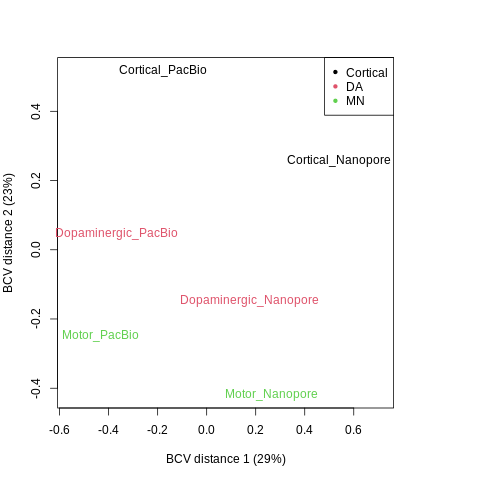

In [18]:
%%R

#distnce between 2 samples = BCV, closer the 2 points are, more similar they are
par(mar=c(5, 4, 4, 6), xpd=TRUE)
plotMDS(d, method="bcv", col=as.numeric(d$samples$group))
legend("topright",as.character(unique(d$samples$group)), col=1:3, pch=20)


## Estimating the Dispersion

In [19]:
%%R

#estimate dispersion by qCML method (common dispersion then tagwise dispersion)
d1 <- estimateCommonDisp(d, verbose=T)
names(d1)

Disp = 0.23963 , BCV = 0.4895 
[1] "counts"            "samples"           "common.dispersion"
[4] "pseudo.counts"     "pseudo.lib.size"   "AveLogCPM"        


In [20]:
%%R

d1 <- estimateTagwiseDisp(d1)
names(d1)

 [1] "counts"             "samples"            "common.dispersion" 
 [4] "pseudo.counts"      "pseudo.lib.size"    "AveLogCPM"         
 [7] "prior.df"           "prior.n"            "tagwise.dispersion"
[10] "span"              


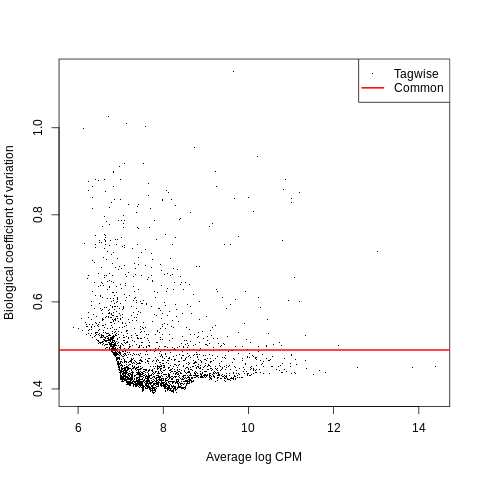

In [21]:
%%R

#plot shows the dispersion estimate 
plotBCV(d1)

## GLM estimates of dispersion

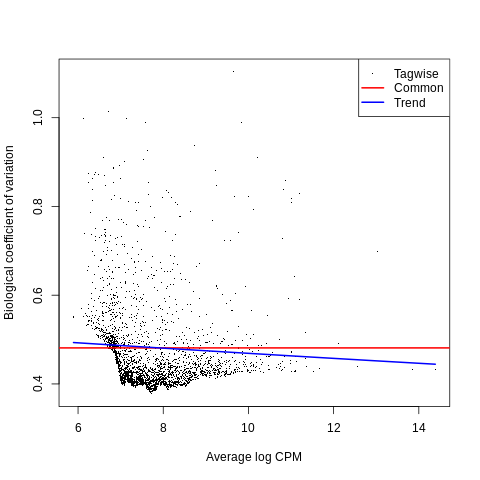

In [22]:
%%R
#Below are 3 methods to estimate a generalized linear model: power, bin.spline 
#and spline. We will use "bin.spline" 

design.mat <- model.matrix(~ 0 + d$samples$group)
colnames(design.mat) <- levels(d$samples$group)
d2 <- estimateGLMCommonDisp(d,design.mat)
d2 <- estimateGLMTrendedDisp(d2,design.mat, method="power")
# You can change method to "auto", "bin.spline", "power", "spline", "bin.loess".
# The default is "auto" which chooses "bin.spline" when > 200 tags and "power" otherwise.
d2 <- estimateGLMTagwiseDisp(d2,design.mat)
plotBCV(d2)

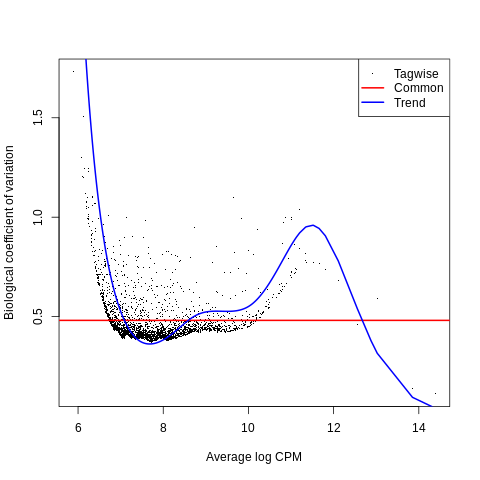

In [23]:
%%R

design.mat <- model.matrix(~ 0 + d$samples$group)
colnames(design.mat) <- levels(d$samples$group)
d2 <- estimateGLMCommonDisp(d,design.mat)
d2 <- estimateGLMTrendedDisp(d2,design.mat, method="spline")

d2 <- estimateGLMTagwiseDisp(d2,design.mat)
plotBCV(d2)

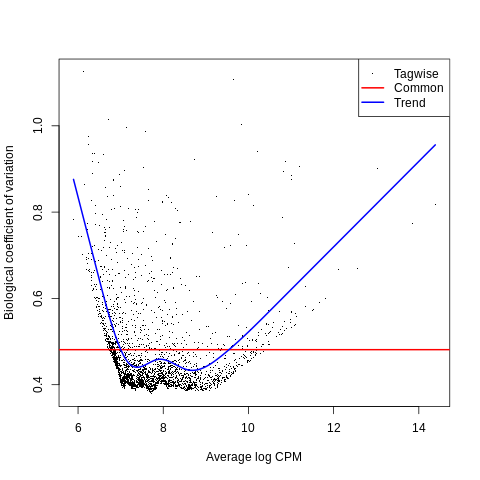

In [24]:
%%R
#we will be using this estimation with the method "bin.spline" (auto)

design.mat <- model.matrix(~ 0 + d$samples$group)
colnames(design.mat) <- levels(d$samples$group)
d2 <- estimateGLMCommonDisp(d,design.mat)
d2 <- estimateGLMTrendedDisp(d2,design.mat, method="bin.spline")

d2 <- estimateGLMTagwiseDisp(d2,design.mat)
plotBCV(d2)

## Comparison 1: NPC-DA vs NPC-Coritcal

In [25]:
%%R

et12 <- exactTest(d1, pair=c(1,2)) #comparison 1: NPC-DA vs NPC-Coritcal
et13 <- exactTest(d1, pair=c(1,3)) #comparison 2: NPC-MN vs NPC-Coritcal
et23 <- exactTest(d1, pair=c(2,3)) #comparison 3: NPC-MN vs NPC-DA


In [26]:
%%R
head(d1)

An object of class "DGEList"
$counts
   Cortical_Nanopore Cortical_PacBio Dopaminergic_Nanopore Dopaminergic_PacBio
1                304              93                   180                 100
9                140              64                   185                 134
13               133              21                    83                  26
14               524              35                    53                  30
18                46              35                   166                 100
20                86              66                   134                 103
   Motor_Nanopore Motor_PacBio
1             241           98
9             249          133
13            209           37
14            159           36
18            124           67
20            103           92

$samples
                         group lib.size norm.factors
Cortical_Nanopore     Cortical   703420    0.8806998
Cortical_PacBio       Cortical   232997    1.0351911
Dopaminergic_Nanopore   

In [2]:
%%R

nnn <- merge(topTags(et12, n=4000),d.full['Geneid'],all.x= TRUE)


UsageError: Cell magic `%%R` not found.


In [48]:
%%R
nnnn <- as.data.frame(nnn)
# topTags(et12, n=4000)
write.csv(nnnn,file = "/content/drive/My Drive/Cortical_DA_et1.csv",row.names = FALSE)

In [49]:
%%R

topTags(et12, n=20)

Comparison of groups:  DA-Cortical 
         logFC   logCPM       PValue          FDR
7969  7.548514 8.883180 6.956139e-15 2.281614e-11
4175 -7.753501 8.452939 1.298590e-13 2.129687e-10
9048  8.101013 8.066773 1.315665e-12 1.215253e-09
5046  5.674112 7.779307 1.482016e-12 1.215253e-09
5137 -6.153984 8.699895 8.568685e-12 5.621058e-09
8535 -5.534954 8.030165 3.683335e-11 2.013556e-08
2033  5.079041 8.888933 2.043620e-10 9.575821e-08
5481 -4.654219 8.073960 4.226745e-10 1.732965e-07
1801  5.334381 8.801063 7.927673e-10 2.889196e-07
3534  4.806357 7.936250 1.303202e-09 4.274504e-07
3396  5.172456 7.224590 1.723216e-09 4.710802e-07
5047  5.706627 7.097241 1.723464e-09 4.710802e-07
8202  4.984922 8.983275 5.614652e-09 1.416620e-06
5183  4.953163 8.026080 2.649197e-08 6.206690e-06
5431  3.964994 7.700415 7.216987e-08 1.578114e-05
2663 -5.452016 6.701658 1.427745e-07 2.926877e-05
5771  4.995454 7.197302 2.039883e-07 3.935774e-05
6667  3.395376 8.376466 4.198078e-07 7.649831e-05
4482 -4.196315

In [42]:
%%R

head(d.full['Geneid'])

           Geneid
1 ENSG00000000003
2 ENSG00000000419
3 ENSG00000000457
4 ENSG00000000460
5 ENSG00000001036
6 ENSG00000001084


In [26]:
%%R
de1 <- decideTestsDGE(et12, adjust.method="BH", p.value=0.05) 
summary(de1)

       DA-Cortical
Down            86
NotSig        3104
Up              90


In [27]:
%%R
new <- merge(d.full,de1,by=0,all.x= FALSE,all.y= TRUE)

head(new)

  Row.names          Geneid Cortical_Nanopore Cortical_PacBio
1         1 ENSG00000000003               304              93
2      1005 ENSG00000083123                68              32
3      1006 ENSG00000083168                66              42
4      1007 ENSG00000083223                42              33
5      1009 ENSG00000083312               364             253
6      1010 ENSG00000083444               214              93
  Dopaminergic_Nanopore Dopaminergic_PacBio Motor_Nanopore Motor_PacBio
1                   180                 100            241           98
2                    72                  60            103           75
3                   118                  85             60           54
4                    74                  65             76           56
5                  1029                 569            672          412
6                    57                  35            127           61
  DA-Cortical
1           0
2           0
3           0
4     

In [ ]:
%%R
install.packages('MASS')

In [29]:
%%R

# head(de1)
library('MASS')


In [30]:
%%R
nn <- as.data.frame(new)
# sorted_nn = nn.sort_values(by='Row.names', ascending=True)
head(nn[order(nn$'Row.names'),])


  Row.names          Geneid Cortical_Nanopore Cortical_PacBio
1         1 ENSG00000000003               304              93
2      1005 ENSG00000083123                68              32
3      1006 ENSG00000083168                66              42
4      1007 ENSG00000083223                42              33
5      1009 ENSG00000083312               364             253
6      1010 ENSG00000083444               214              93
  Dopaminergic_Nanopore Dopaminergic_PacBio Motor_Nanopore Motor_PacBio
1                   180                 100            241           98
2                    72                  60            103           75
3                   118                  85             60           54
4                    74                  65             76           56
5                  1029                 569            672          412
6                    57                  35            127           61
  DA-Cortical
1           0
2           0
3           0
4     

In [31]:
%%R

write.csv(nn,file = "/content/drive/My Drive/Cortical_DA_1.csv",row.names = FALSE)

In [32]:
%%R

de1

TestResults matrix
   DA-Cortical
1            0
9            0
13           0
14          -1
18           0
3275 more rows ...


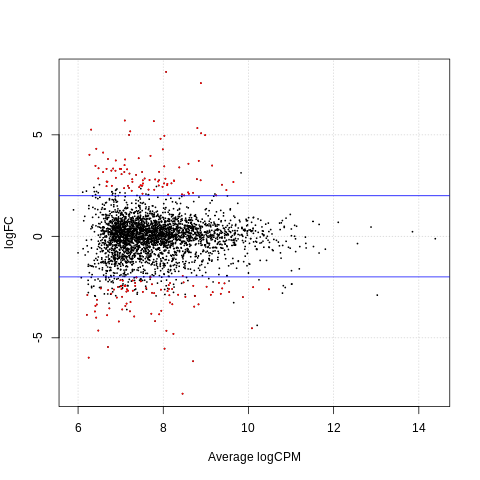

In [ ]:
%%R
# differentially expressed tags from the naive method in d1
de1tags12 <- rownames(d1)[as.logical(de1)] 
plotSmear(et12, de.tags=de1tags12) 
abline(h = c(-2, 2), col = "blue")

In [ ]:
#GLM testing for differential expression
%%R

fit <- glmFit(d2, design.mat)
# compare (group 1 - group 2) to 0:
# this is equivalent to comparing group 1 to group 2
lrt12 <- glmLRT(fit, contrast=c(1,-1,0))
lrt13 <- glmLRT(fit, contrast=c(1,0,-1))
lrt23 <- glmLRT(fit, contrast=c(0,1,-1))

In [ ]:
%%R
topTags(lrt12, n=2)

Coefficient:  1*Cortical -1*DA 
         logFC   logCPM       LR       PValue          FDR
7969 -7.558967 8.883333 71.12323 3.355962e-17 1.100756e-13
4175  7.762086 8.452552 58.70116 1.835330e-14 3.009941e-11


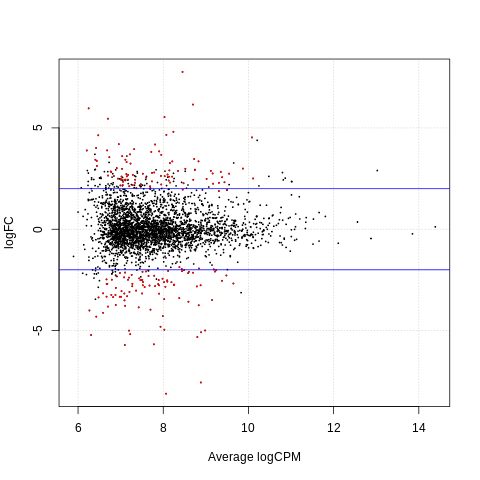

In [ ]:
%%R
de2 <- decideTestsDGE(lrt12, adjust.method="BH", p.value = 0.05)
de2tags12 <- rownames(d2)[as.logical(de2)]
plotSmear(lrt12, de.tags=de2tags12)
abline(h = c(-2, 2), col = "blue")

## Comparison 2: NPC-MN vs NPC-Coritcal

In [ ]:
%%R
topTags(et13, n=2) 

Comparison of groups:  MN-Cortical 
         logFC   logCPM       PValue          FDR
8306  7.832814 8.832794 7.094836e-15 2.327106e-11
5481 -6.128132 8.073960 6.257512e-14 1.026232e-10


In [ ]:
%%R

de1 <- decideTestsDGE(et13, adjust.method="BH", p.value=0.05) 
summary(de1)

       MN-Cortical
Down           101
NotSig        3112
Up              67


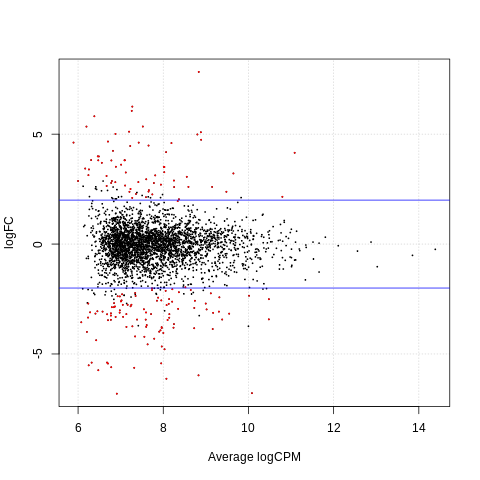

In [ ]:
%%R
# differentially expressed tags from the naive method in d1
de1tags13 <- rownames(d1)[as.logical(de1)] 
plotSmear(et13, de.tags=de1tags13) 
abline(h = c(-2, 2), col = "blue")

In [ ]:
#GLM testing for differential expression
%%R

fit <- glmFit(d2, design.mat)
# compare (group 1 - group 2) to 0:
# this is equivalent to comparing group 1 to group 2
topTags(lrt13, n=2)

Coefficient:  1*Cortical -1*MN 
         logFC   logCPM       LR       PValue          FDR
8306 -7.858928 8.832929 75.18778 4.280073e-18 1.403864e-14
7467  5.978764 8.827359 58.66567 1.868742e-14 2.172908e-11


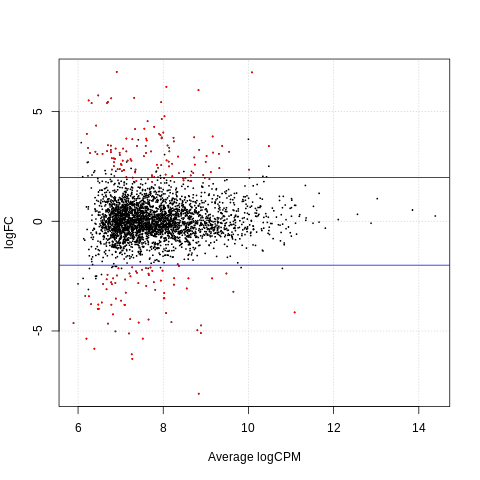

In [ ]:
%%R
de2 <- decideTestsDGE(lrt13, adjust.method="BH", p.value = 0.05)
de2tags13 <- rownames(d2)[as.logical(de2)]
plotSmear(lrt13, de.tags=de2tags13)
abline(h = c(-2, 2), col = "blue")


## Comparison 3: NPC-MN vs NPC-DA

In [ ]:
%%R
topTags(et23, n=2) 

Comparison of groups:  MN-DA 
         logFC   logCPM       PValue          FDR
5740 -5.694929 7.632419 2.357568e-12 7.732823e-09
4175  6.838685 8.452939 2.546410e-11 4.176113e-08


In [ ]:
%%R

de1 <- decideTestsDGE(et23, adjust.method="BH", p.value=0.05) 
summary(de1)

       MN-DA
Down      73
NotSig  3156
Up        51


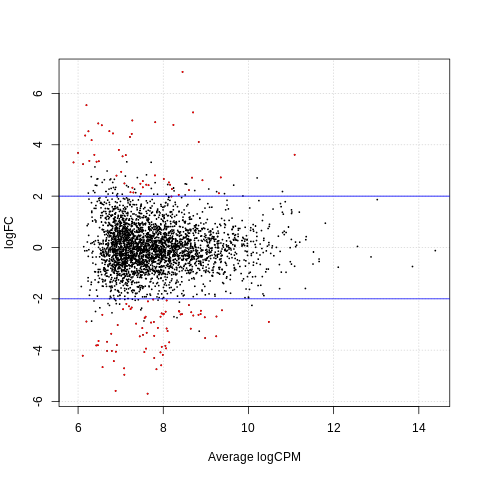

In [ ]:
%%R
# differentially expressed tags from the naive method in d1
de1tags23 <- rownames(d1)[as.logical(de1)] 
plotSmear(et23, de.tags=de1tags23) 
abline(h = c(-2, 2), col = "blue")

In [ ]:
#GLM testing for differential expression
%%R

fit <- glmFit(d2, design.mat)
# compare (group 1 - group 2) to 0:
# this is equivalent to comparing group 1 to group 2
topTags(lrt23, n=2)

Coefficient:  1*DA -1*MN 
         logFC   logCPM       LR       PValue          FDR
5740  5.690823 7.632418 51.45291 7.333523e-13 2.405396e-09
4175 -6.830282 8.452552 47.44966 5.643460e-12 9.255275e-09


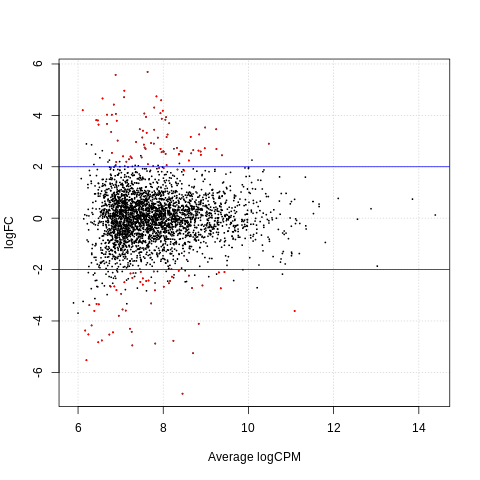

In [ ]:
%%R
de2 <- decideTestsDGE(lrt23, adjust.method="BH", p.value = 0.05)
de2tags23 <- rownames(d2)[as.logical(de2)]
plotSmear(lrt23, de.tags=de2tags23)
abline(h = c(-2, 2), col = "blue")

## 3 way comparison (not done yet)

In [ ]:
%%R

# Fit the NB GLMs with QL methods

d <- estimateDisp(d2, design.mat)
fit <- glmQLFit(d2, design.mat)
results <- glmQLFTest(fit,coef=1:3)
topTags(results,n=2)


Coefficient:  Cortical DA MN 
     logFC.Cortical  logFC.DA  logFC.MN   logCPM        F       PValue
6167      -11.35647 -13.65413 -15.56010 7.338277 752.9030 5.019546e-08
1305      -12.20330 -13.02501 -12.74302 7.345349 751.4959 5.047296e-08
              FDR
6167 9.092531e-07
1305 9.092531e-07


In [ ]:
# %%R
# # DGELRT
# de2 <- decideTestsDGE(results, adjust.method="BH", p.value = 0.05)
# de2tags123 <- rownames(d2)[as.logical(de2)]


# plotSmear(results, de.tags=de2tags123)
# # # abline(h = c(-2, 2), col = "blue")

In [ ]:
%%R
# DGELRT
# DGEExact
d2

An object of class "DGEList"
$counts
   Cortical_Nanopore Cortical_PacBio Dopaminergic_Nanopore Dopaminergic_PacBio
1                304              93                   180                 100
9                140              64                   185                 134
13               133              21                    83                  26
14               524              35                    53                  30
18                46              35                   166                 100
   Motor_Nanopore Motor_PacBio
1             241           98
9             249          133
13            209           37
14            159           36
18            124           67
3275 more rows ...

$samples
                         group lib.size norm.factors
Cortical_Nanopore     Cortical   703420    0.8806998
Cortical_PacBio       Cortical   232997    1.0351911
Dopaminergic_Nanopore       DA   659020    0.9762880
Dopaminergic_PacBio         DA   365966    1.0493958
Motor_Nan